In [1]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
import pickle

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [3]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.

'''
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
'''

#if you do NOT have RAM >= 12GB, use the code below.
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [4]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec
    

In [5]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [6]:
from tqdm import tqdm
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in tqdm(idf_title_vectorizer.vocabulary_.keys()):
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val

100%|████████████████████████████████████████████████████████████████████████████| 12609/12609 [07:04<00:00, 29.70it/s]


In [7]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in tqdm(data['title']):
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

100%|██████████████████████████████████████████████████████████████████████████| 16042/16042 [00:11<00:00, 1386.52it/s]


## Weighted Euclidean-distance based similarity using Idf-weighted W2V , brand and color And Image data :-

In [8]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

ASIN : B01M0IDUCV
Brand : Premise
euclidean distance from input : 3.2340671168640255e-06


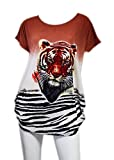

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Amazon Url: www.amzon.com/dp/B00JXQB5FQ
ASIN : B01N4NQ7LX
Brand : CeCe by Cynthia Steffe
euclidean distance from input : 16.875468826293947


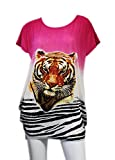

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Amazon Url: www.amzon.com/dp/B00JXQASS6
ASIN : B01IU645VU
Brand : Outback Red
euclidean distance from input : 22.643433124244417


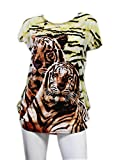

Product Title:  yellow tiger tshirt tiger stripes  l 
Amazon Url: www.amzon.com/dp/B00JXQCUIC
ASIN : B01FQLKKMK
Brand : SLJD
euclidean distance from input : 24.22754843872806


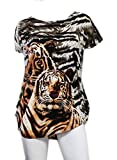

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Amazon Url: www.amzon.com/dp/B00JXQCWTO
ASIN : B01MXI5L4G
Brand : Maison Margiela MM6
euclidean distance from input : 25.56331198853275


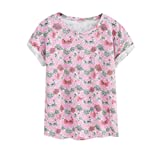

Product Title:  kawaii pastel tops tees pink flower design 
Amazon Url: www.amzon.com/dp/B071FCWD97
ASIN : B071VZCT5W
Brand : Chloe K.
euclidean distance from input : 25.859306430816652


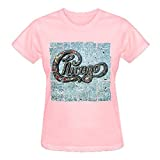

Product Title:  chicago chicago 18 shirt women pink 
Amazon Url: www.amzon.com/dp/B01GXAZTRY
ASIN : B00K77AN5S
Brand : Russell Collection
euclidean distance from input : 25.88813982009888


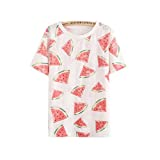

Product Title:  womens thin style tops tees pastel watermelon print 
Amazon Url: www.amzon.com/dp/B01JUNHBRM
ASIN : B00L8RE3PC
Brand : JSDY-Cloth
euclidean distance from input : 25.893363857269286


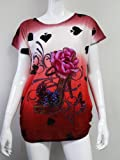

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Amazon Url: www.amzon.com/dp/B00JV63QQE
ASIN : B00YC92VRU
Brand : Display Promotion
euclidean distance from input : 25.99268188847895


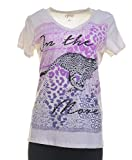

Product Title:  edv cheetah run purple multi xl 
Amazon Url: www.amzon.com/dp/B01CUPYBM0
ASIN : B06ZYLKPRT
Brand : Xhilaration
euclidean distance from input : 26.010244502193597


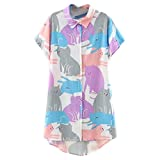

Product Title:  abaday multicolor cartoon cat print short sleeve longline shirt large 
Amazon Url: www.amzon.com/dp/B01CR57YY0
ASIN : B01MU874KK
Brand : XINUO
euclidean distance from input : 26.035226920980172


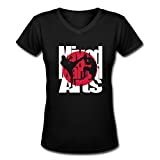

Product Title:  women japanese mixed martial arts teeblack tshirts hgiorgis xxl black 
Amazon Url: www.amzon.com/dp/B01JQ096HW
ASIN : B071LMW4YG
Brand : Standard James Perse
euclidean distance from input : 26.05537512940189


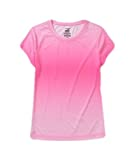

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Amazon Url: www.amzon.com/dp/B01F7PHXY8
ASIN : B01MXMG6KB
Brand : Mogul Interior
euclidean distance from input : 26.060921610958246


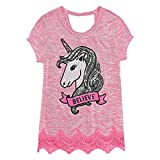

Product Title:  miss chievous juniors striped peplum tank top medium shadowpeach 
Amazon Url: www.amzon.com/dp/B0177DM70S
ASIN : B074MJPLCB
Brand : BollyDoll
euclidean distance from input : 26.07773418797846


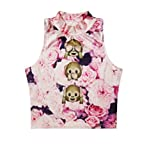

Product Title:  kingde star pink flower dog stamp sleeveless vestbqn24 
Amazon Url: www.amzon.com/dp/B015H3W9BM
ASIN : B01MG83UB4
Brand : MaxMara
euclidean distance from input : 26.136662486928657


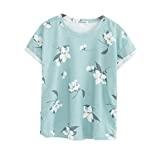

Product Title:  kawaii pastel tops tees baby blue flower design 
Amazon Url: www.amzon.com/dp/B071SBCY9W
ASIN : B01MQWKWME
Brand : IGotCollared
euclidean distance from input : 26.20654862564823


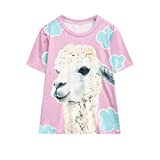

Product Title:  summer alpaca 3d pastel casual loose tops tee design 
Amazon Url: www.amzon.com/dp/B01I80A93G
ASIN : B01MSZ1EO7
Brand : Esprit
euclidean distance from input : 26.271339160621373


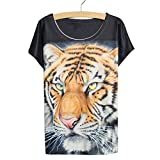

Product Title:  yichun womens tiger printed summer tshirts tops 
Amazon Url: www.amzon.com/dp/B010NN9RXO
ASIN : B0060MKVX8
Brand : None
euclidean distance from input : 26.286569786252464


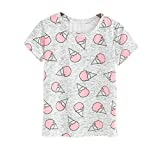

Product Title:  womens tops tees pastel peach ice cream cone print 
Amazon Url: www.amzon.com/dp/B0734GRKZL
ASIN : B00D2J5HPO
Brand : Kaia
euclidean distance from input : 26.305827430623726


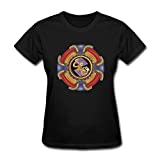

Product Title:  dasy womens neck electric light orchestra logo shirt xxlarge black 
Amazon Url: www.amzon.com/dp/B016EXUZC4
ASIN : B071KG15YM
Brand : KENDALL + KYLIE
euclidean distance from input : 26.33173889077392


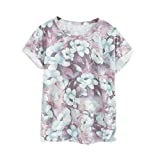

Product Title:  kawaii cotton pastel tops tees pink flower design 
Amazon Url: www.amzon.com/dp/B071P4YKH5


In [9]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])


from IPython.display import display, Image, SVG, Math, YouTubeVideo

def idf_w2v_brand(doc_id, w1, w2, w3, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    doc_id = asins.index(df_asins[doc_id])
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    image_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist + w3*image_dist)/float(w1 + w2 + w3)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        #heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
           # print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])
        print('='*125)

idf_w2v_brand(12566, 5, 5, 10, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j

ASIN : B01M0IDUCV
Brand : Premise
euclidean distance from input : 4.042583896080032e-06


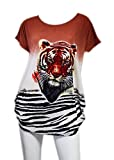

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Amazon Url: www.amzon.com/dp/B00JXQB5FQ
ASIN : B01N4NQ7LX
Brand : CeCe by Cynthia Steffe
euclidean distance from input : 20.34433603286743


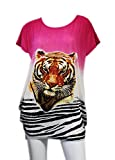

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Amazon Url: www.amzon.com/dp/B00JXQASS6
ASIN : B01IU645VU
Brand : Outback Red
euclidean distance from input : 27.642855794832162


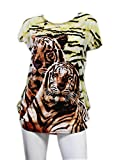

Product Title:  yellow tiger tshirt tiger stripes  l 
Amazon Url: www.amzon.com/dp/B00JXQCUIC
ASIN : B01FQLKKMK
Brand : SLJD
euclidean distance from input : 29.622998006746222


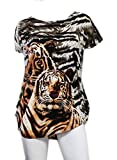

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Amazon Url: www.amzon.com/dp/B00JXQCWTO
ASIN : B01MXI5L4G
Brand : Maison Margiela MM6
euclidean distance from input : 31.292702539369515


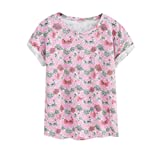

Product Title:  kawaii pastel tops tees pink flower design 
Amazon Url: www.amzon.com/dp/B071FCWD97
ASIN : B071VZCT5W
Brand : Chloe K.
euclidean distance from input : 31.824131584167482


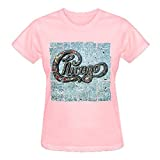

Product Title:  chicago chicago 18 shirt women pink 
Amazon Url: www.amzon.com/dp/B01GXAZTRY
ASIN : B00K77AN5S
Brand : Russell Collection
euclidean distance from input : 31.860175132751465


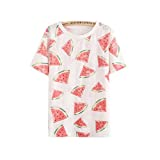

Product Title:  womens thin style tops tees pastel watermelon print 
Amazon Url: www.amzon.com/dp/B01JUNHBRM
ASIN : B00L8RE3PC
Brand : JSDY-Cloth
euclidean distance from input : 31.866704368591307


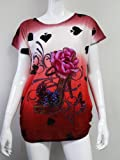

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Amazon Url: www.amzon.com/dp/B00JV63QQE
ASIN : B06ZYLKPRT
Brand : Xhilaration
euclidean distance from input : 31.900431690009157


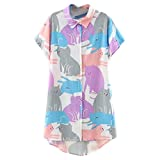

Product Title:  abaday multicolor cartoon cat print short sleeve longline shirt large 
Amazon Url: www.amzon.com/dp/B01CR57YY0
ASIN : B071LMW4YG
Brand : Standard James Perse
euclidean distance from input : 31.90778041641419


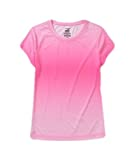

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Amazon Url: www.amzon.com/dp/B01F7PHXY8
ASIN : B00YC92VRU
Brand : Display Promotion
euclidean distance from input : 31.93183722588866


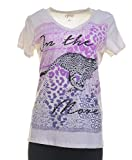

Product Title:  edv cheetah run purple multi xl 
Amazon Url: www.amzon.com/dp/B01CUPYBM0
ASIN : B01MXMG6KB
Brand : Mogul Interior
euclidean distance from input : 31.963778457434692


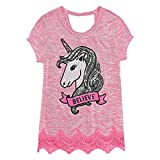

Product Title:  miss chievous juniors striped peplum tank top medium shadowpeach 
Amazon Url: www.amzon.com/dp/B0177DM70S
ASIN : B01MU874KK
Brand : XINUO
euclidean distance from input : 31.98501515481322


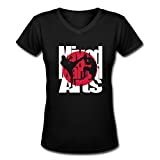

Product Title:  women japanese mixed martial arts teeblack tshirts hgiorgis xxl black 
Amazon Url: www.amzon.com/dp/B01JQ096HW
ASIN : B074MJPLCB
Brand : BollyDoll
euclidean distance from input : 32.03815159890502


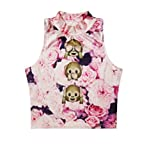

Product Title:  kingde star pink flower dog stamp sleeveless vestbqn24 
Amazon Url: www.amzon.com/dp/B015H3W9BM
ASIN : B01MQWKWME
Brand : IGotCollared
euclidean distance from input : 32.09674869339173


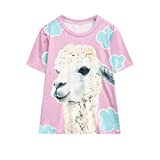

Product Title:  summer alpaca 3d pastel casual loose tops tee design 
Amazon Url: www.amzon.com/dp/B01I80A93G
ASIN : B01MG83UB4
Brand : MaxMara
euclidean distance from input : 32.1118096837744


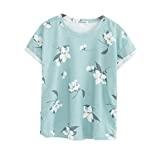

Product Title:  kawaii pastel tops tees baby blue flower design 
Amazon Url: www.amzon.com/dp/B071SBCY9W
ASIN : B0060MKVX8
Brand : None
euclidean distance from input : 32.15110740666138


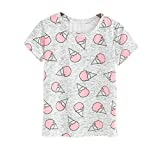

Product Title:  womens tops tees pastel peach ice cream cone print 
Amazon Url: www.amzon.com/dp/B0734GRKZL
ASIN : B01MSZ1EO7
Brand : Esprit
euclidean distance from input : 32.17773567001527


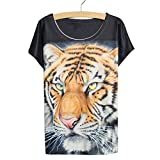

Product Title:  yichun womens tiger printed summer tshirts tops 
Amazon Url: www.amzon.com/dp/B010NN9RXO
ASIN : B00WTE3XC2
Brand : HUGO BOSS
euclidean distance from input : 32.24052438740479


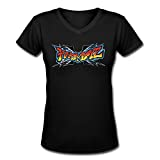

Product Title:  cling womens hardy boyz wwe logo vneck tshirt black 
Amazon Url: www.amzon.com/dp/B01A82FFBI
ASIN : B01LMFZKXS
Brand : Books.And.More
euclidean distance from input : 32.29815364639466


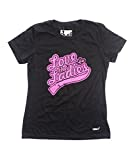

Product Title:  new balance womens blackpink love ladies shirt us small 
Amazon Url: www.amzon.com/dp/B071ZM3N95


In [10]:
idf_w2v_brand(12566, 50, 10, 100, 20)